In [1823]:
import pandas as pd
import numpy as np
import torch
from matplotlib import pyplot as plt
%matplotlib inline

In [1824]:
filename = "./data/wine.csv"
df = pd.read_csv(filename)
df = df.sample(frac=1).reset_index(drop=True)
df = df.drop('index', axis=1)
print(df.shape)
print(df["quality"].value_counts())

(6497, 12)
6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64


In [1825]:
from sklearn.utils import resample

#Resample:
df_majority = df[df['quality'] == 6]
for i in range(3,10):
    majority_len = df[df['quality'] == 6].shape[0]
    if i != 6:
        minority_len = df[df['quality'] == i].shape[0]

        df_minority = df[df['quality'] == i]

        df_minority_upsampled = resample(df_minority, 
                                        replace=True,               
                                        n_samples=majority_len)

        df_majority = df_majority.append(df_minority_upsampled)
df = df_majority
print(df.shape)
print(df["quality"].value_counts())
df = df.sample(frac=1).reset_index(drop=True)

(19852, 12)
3    2836
4    2836
5    2836
6    2836
7    2836
8    2836
9    2836
Name: quality, dtype: int64


In [1826]:
train_test_split_fraction = 0.70
split_index = int(df.shape[0] * train_test_split_fraction)
df_train = df[:split_index]
df_test = df[split_index:]

target = pd.get_dummies(df['quality']).values

In [1827]:
X_train = df_train.drop('quality', axis = 1).values
X_test = df_test.drop('quality', axis = 1).values

y_train = target[:split_index]
y_test = target[split_index:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(13896, 11)
(5956, 11)
(13896, 7)
(5956, 7)


In [1828]:
X_train = torch.tensor(X_train, dtype=torch.float64)
y_train = torch.tensor(y_train, dtype=torch.float64)
X_test = torch.tensor(X_test, dtype=torch.float64)
y_test = torch.tensor(y_test, dtype=torch.float64)

In [1829]:
nb_hidden_neurons = 200
nb_classes = len(pd.unique(df['quality']))
nb_classes

7

In [1830]:
import torch.nn as nn

class Network(nn.Module):

    def __init__(self, nb_features):
        """Here we define the layers
        """

        super().__init__()
        
        self.layer_1 =  nn.Linear(nb_features, 100)
        self.layer_2 =  nn.Linear(100, 200)
        self.layer_3 =  nn.Linear(200, 200)
        self.layer_4 =  nn.Linear(200, 200)
        self.layer_5 =  nn.Linear(200, 100)
        self.layer_6 =  nn.Linear(100, 50)
        self.layer_out =  nn.Linear(50, nb_classes)
        
        

    def forward(self,x):
        """Here we combine the layers
        """
        
        activation_function = nn.SiLU() 
        last_layer_activation = nn.Softmax()
        
        output_first_layer = activation_function(self.layer_1(x))
        output_second_layer = activation_function(self.layer_2(output_first_layer))
        output_third_layer = activation_function(self.layer_3(output_second_layer))
        output_forth_layer = activation_function(self.layer_4(output_third_layer))
        output_fith_layer = activation_function(self.layer_5(output_forth_layer))
        output_sixth_layer = activation_function(self.layer_6(output_fith_layer))
        prediction = last_layer_activation(self.layer_out(output_sixth_layer))
        return prediction

In [1831]:
my_nn = Network(nb_features=X_train.shape[1])
my_nn

Network(
  (layer_1): Linear(in_features=11, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=200, bias=True)
  (layer_3): Linear(in_features=200, out_features=200, bias=True)
  (layer_4): Linear(in_features=200, out_features=200, bias=True)
  (layer_5): Linear(in_features=200, out_features=100, bias=True)
  (layer_6): Linear(in_features=100, out_features=50, bias=True)
  (layer_out): Linear(in_features=50, out_features=7, bias=True)
)

In [1832]:
criterion = nn.MSELoss() 
learning_rate = 0.001 
optimizer = torch.optim.AdamW(my_nn.parameters(), lr=learning_rate)

In [1833]:
def training(batch_size : int, nb_steps_loss_sum : int):
    
    loss_list = []
    running_loss = 0
    batch_nb = 0

    for epoch in range(0,50): # Number of times to iterate through the complete dataset
        for idx in range(0, X_train.shape[0], batch_size):
            
            # Get input and output
            input_batch = X_train[idx:idx + batch_size]
            target = y_train[idx:idx + batch_size]
            
            # TO COMPLETE:
            # - zero gradient buffers
            optimizer.zero_grad()
            # - compute the forward pass
            y_pred = my_nn(input_batch.float())
            # - compute the loss
            loss = criterion(y_pred, target.float())
            # - backpropagate
            loss.backward()
            # - do a step
            optimizer.step()
          
            
            # Save the loss every `running_loss_steps` batches
            running_loss += loss.item()
            save_loss_condition = batch_nb % nb_steps_loss_sum == (nb_steps_loss_sum - 1)
            
            if save_loss_condition:    
                loss_list.append(running_loss)
                running_loss = 0.0


            batch_nb+= 1
        
    return loss_list

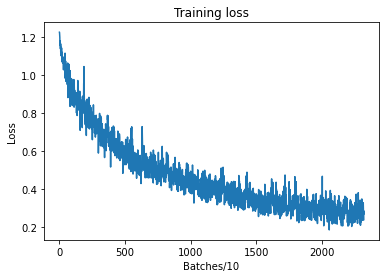

In [1834]:
nb_steps_loss_sum = 10
loss = training(batch_size=30, nb_steps_loss_sum=nb_steps_loss_sum)

# Plotting the loss over training
plt.figure()
plt.plot(range(0, len(loss)), loss)
plt.xlabel(f"Batches/{nb_steps_loss_sum}")
plt.ylabel("Loss")
plt.title("Training loss")
plt.show()
plt.close()

In [1835]:
def computeScore(X, y):
    correct = 0
    total = 0
    batch_size = 30
    with torch.no_grad():
        for idx in range(0, X.shape[0], batch_size):
            # TO COMPLETE:
            # - get the `batch_size` number of input samples
            total += 1
            # - compute the prediction of the neural network
            output = my_nn(X.float())
            # - get the max of the prediction (e.g. get the most likely class)
            # This can be done using `torch.max`.
            predicted = torch.max(output, 1)
            # - get the max of the target (e.g. correct class)
            target_pred = torch.max(y, 1)
            # - check if the prediction is correct and count it
            if predicted[1][idx] == target_pred[1][idx]:
                correct += 1
            # - count every sample
            
    accuracy = correct/total * 100
    print(f"Accuracy of the network on the {total} samples: {accuracy:.2f}%")

In [1836]:
computeScore(X_train, y_train)
computeScore(X_test, y_test)

Accuracy of the network on the 464 samples: 85.34%
Accuracy of the network on the 199 samples: 79.40%
